#### Topic Modeling ___ Gensim

Here, we will do topic modeling using LDA from gensim library and see the diff with LDA in sklearn 


We will do cybersecurity category only for this one

In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import nltk
from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english", ignore_stopwords=True)

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
#nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet


#from sklearn.utils import *


In [4]:
# gensim import
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# from gensim.utils import simple_preprocess
# from gensim.parsing.preprocessing import STOPWORDS

In [19]:
# let's create our own stopwords library, removing the most frequent AV terms as well
stopwords_AV = [
                # we removed all the quastionning indicators (who, when...) and negation from stopwords
                'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll",
                "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 
                'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',
                'themselves',  'this', 'that', "that'll", 'these', 'those', 'am', 
                'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
                'did', 'doing', 'a', 'an', 'the', 'and', 'or', 'of',
                'at', 'by', 'for', 'with',  'into', 'through', 'during', 
                'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 
                 'here', 'there', 'all', 'any', 
                'both' , 'more', 'other', 'such', 'own', 
                'same', 'so', 'than', 'too', 'very', 's', 't', 'just', 
                 'now', 'd', 'll', 'm', 'o', 're', 've', 'y',  'ma',
                # context words -- will be kept for more context
                # 'driving', 'self', 'vehicles', 'autonomous', 'car', 'driverless'
               ]

In [5]:
# data cleaning functions

# WORDNET LEMMATIZER (with appropriate pos tags)

lemmatizer = WordNetLemmatizer()

# Define function to lemmatize each word with its POS tag

# POS_TAGGER_FUNCTION : TYPE 1
def pos_tagger(nltk_tag):
	if nltk_tag.startswith('J'):
		return wordnet.ADJ
	elif nltk_tag.startswith('V'):
		return wordnet.VERB
	elif nltk_tag.startswith('N'):
		return wordnet.NOUN
	elif nltk_tag.startswith('R'):
		return wordnet.ADV
	else:		
		return None

def lemmatization(sentence):
    # tokenize the sentence and find the POS tag for each token
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))

    # we use our own pos_tagger function to make things simpler to understand.
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:	
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)

    return lemmatized_sentence


In [6]:

# cleaning the Data 

# 1. removing twitter handkes


def remove_pattern(input_text, pattern):
    r=re.findall(pattern,input_text)
    for i in r:
        input_text=re.sub(i,'',input_text)
    return input_text

def cleaning_data(df2, column='tweet'):
    df2 =df2.drop_duplicates()
    
    # 2.removing tweeter handles @user
    df2['clean_twt'] = np.vectorize(remove_pattern)(df2[column],'@[\w]*')
    df2['clean_twt'] = np.vectorize(remove_pattern)(df2['clean_twt'],'#[\w]*')
    #df2['clean_twt'] = df2['clean_twt'].apply (lambda x :  ' '.join(re.sub("@[A-Za-z0-9_]+","", x).split())
    df2['clean_twt'] = df2['clean_twt'].str.replace('http\S+|www\S+','', case=False)

    ##spacy cleaning_ contractions removal
    df2.loc[:15,'clean_twt'] = df2.loc[:15,'clean_twt'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)])) 
    df2['clean_twt'] = df2['clean_twt'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)])) 
    
    
    # 3.rm punctuation, numbers, special char
    df2['clean_twt'] = df2['clean_twt'].str.replace('[^A-Za-z0-9]+',' ')
    df2['clean_twt'] = df2['clean_twt'].apply (lambda x : ' '.join([item for item in str(x).split() if not item.isdigit()]))
    # words with digirs
    df2['clean_twt'] = df2['clean_twt'].apply (lambda x : ' '.join(s for s in x.split() if not any(c.isdigit() for c in s)))

    # 5. lowercase
    df2['clean_twt'] = df2['clean_twt'].apply(lambda x: ''.join([w for w in x.lower()]))

    #lemmatization with context
    df2['clean_twt'] = df2['clean_twt'].apply(lambda x: ' '.join([ lemmatization(item) for item in str(x).split() if item not in stopwords_AV]))
    
    #spacy cleaning_ contractions removal
    df2['clean_twt'] = df2['clean_twt'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)])) 
    
    #stop = stopwords.words('english')
   # df2['clean_twt'] = df2['clean_twt'].apply(lambda x: ' '.join([item for item in str(x).split() if item not in stopwords_AV ]))
    
    # let remove all stopwords; they weight in the topic modeling
    stop = stopwords.words('english')
    df2['clean_twt'] = df2['clean_twt'].apply(lambda x: ' '.join([item for item in str(x).split() if item not in stop]))
    
    # for more context understanding and exploitation, we want to change all synonyms of AVs like driverless car/vehicle,
    # self driving car/vehicle; self drive vehicle/car, autonomous car by 'autinimous vehicle)

    elts_replace = ['driverless car', 'driverless vehicle', 'self driving car','self driving vehicle', 
                'self drive vehicle', 'self drive car', 'autonomous car' , 'drive self car']
    # replacing those words with 'autonomous vehicles'
    df2['clean_twt_re'] = df2['clean_twt']

    
    for item in elts_replace:
        df2['clean_twt_re'] = df2['clean_twt_re'].str.replace(item,'automate vehicle')
    
    df2['clean_twt_re'] = df2['clean_twt_re'].str.replace('car','vehicle')
    df2['clean_twt_re'] = df2['clean_twt_re'].str.replace('self drive','automate')
    df2['clean_twt_re'] = df2['clean_twt_re'].str.replace('selfdrive','automate')
    df2['clean_twt_re'] = df2['clean_twt_re'].str.replace('selfdriving','automate')
    df2['clean_twt_re'] = df2['clean_twt_re'].str.replace('driverless','automate')
    df2['clean_twt_re'] = df2['clean_twt_re'].str.replace('automated','automate')
    df2['clean_twt_re'] = df2['clean_twt_re'].str.replace('autonomous','automate')
    
    
    
    return df2




In [25]:
# other preprocessing process
stop_words = stopwords.words('english')
stop_words.extend(['come','try','go','get','make','would','really','like','great','came','got','rt']) 

def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]




def remove_stopwords(texts):
    out = [[word for word in simple_preprocess(str(doc))
            if word not in stop_words]
            for doc in texts]
    return out

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

def get_corpus(df, column):
    df[column] = strip_newline(df[column])
    words = list(sent_to_words(df[column]))
    words = remove_stopwords(words)
    bigram_mod = bigrams(words)
    bigram = [bigram_mod[review] for review in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    
    return corpus, id2word, bigram



In [160]:
# uploading the data
# getting the data and cleaning it 

df_sec_twit = pd.read_csv("Categorized Data/Twitter/accidents.csv", encoding_errors='ignore')
df_sec_redt = pd.read_csv("Categorized Data/Reddit/Cybersecurity_Reddit.csv", encoding_errors='ignore')



In [162]:
df_sec_twit.shape

(730, 1)

In [163]:
# cleaning the tweets and comments
df_sec_twit = cleaning_data(df_sec_twit,'tweet')
df_sec_redt = cleaning_data(df_sec_redt,'comment')

/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_4952/2152554357.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['clean_twt'] = np.vectorize(remove_pattern)(df2[column],'@[\w]*')
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_4952/2152554357.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['clean_twt'] = np.vectorize(remove_pattern)(df2['clean_twt'],'#[\w]*')
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_4952/2152554357.py:19: FutureWarning: The default va

/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_4952/2152554357.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['clean_twt'] = df2['clean_twt'].str.replace('[^A-Za-z0-9]+',' ')


In [164]:
train_corpus4_twit, train_id2word_twit, bigram_train_twit = get_corpus(df_sec_twit,'clean_twt_re')
train_corpus4_redt, train_id2word_redt, bigram_train_redt = get_corpus(df_sec_redt,'clean_twt_re')


/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_4952/1534098437.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = strip_newline(df[column])


#####  chosing the number of topics for LDA
Create a handful of LDA models with different topic values, then see how these perform in the supervised classification model training. This is specific to my goals here, since my ultimate aim is to see if the topic distributions have predictive value.

### LDA Model in Gensim
Note that running eval_every=1 does this in batches of chunksize batches. The 20 is chosen from a HDP Process Test on the same data in another notebook

In [165]:
import logging
import warnings
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train4 = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus4_twit,
                           num_topics=5,
                           id2word=train_id2word_twit,
                           random_state=100,
                           chunksize=10,
                           workers=7, # Num. Processing Cores - 1
                           passes=10,
                           eval_every = 1,
                           iterations=100,
                           per_word_topics=True)
    lda_train4.save('lda_train4.model')

In [166]:

lda_train4.print_topics(10,num_words=15)[:10]

[(0,
  '0.075*"system" + 0.060*"link" + 0.052*"time" + 0.049*"safety" + 0.046*"accident" + 0.042*"via" + 0.040*"liability" + 0.039*"could" + 0.033*"tech" + 0.030*"collision" + 0.027*"ai" + 0.024*"still" + 0.022*"less" + 0.022*"new" + 0.021*"law"'),
 (1,
  '0.094*"drive" + 0.054*"accident" + 0.036*"human" + 0.036*"driver" + 0.032*"safe" + 0.027*"safety" + 0.025*"control" + 0.024*"new_york" + 0.023*"need" + 0.022*"fully" + 0.022*"cause" + 0.022*"auto" + 0.021*"many" + 0.021*"elon_musk" + 0.020*"regulator"'),
 (2,
  '0.101*"accident" + 0.069*"road" + 0.065*"driver" + 0.057*"tesla" + 0.045*"say" + 0.038*"test" + 0.037*"software" + 0.033*"need" + 0.032*"well" + 0.027*"responsible" + 0.024*"look" + 0.023*"problem" + 0.022*"lead" + 0.022*"day" + 0.021*"maybe"'),
 (3,
  '0.098*"tesla" + 0.060*"report" + 0.056*"accident" + 0.052*"involve" + 0.036*"nearly" + 0.033*"use" + 0.033*"full" + 0.032*"cause" + 0.032*"know" + 0.026*"datum" + 0.023*"much" + 0.019*"injury" + 0.019*"release" + 0.017*"year" 

In [167]:
df_sec_twit.reset_index(inplace=True)

In [168]:
def format_topics_sentences(ldamodel=None, corpus=train_corpus4_redt, texts=bigram_train_redt, cleaned_text=bigram_train_redt):
    #init output
    sent_topics_df = pd.DataFrame()

    # get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        #print (row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        #get the dominant topic, Perc Contribubion and keywords for each document
        for j, (topic_num,prop_topic) in enumerate(row):
            if j==0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # add original text to the end of the output
    contents = pd.Series(texts)
    # cleaned_text = 
    sent_topics_df = pd.concat([sent_topics_df, contents, cleaned_text], axis =1)
    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel= lda_train4, corpus=train_corpus4_twit , texts=bigram_train_twit, cleaned_text=df_sec_twit.clean_twt_re  )

# format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Document_Topic', 'Topic_Perc_Contrib', 'Keywords','Text', 'Cleaned_Text']

with pd.option_context('display.max_colwidth', None):
    display(df_dominant_topic.head(4))


    

/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_4952/573457323.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/43/x1c5gssn601526kgzp78x6dm0000gn/T/ipykernel_4952/573457323.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Document_Topic,Topic_Perc_Contrib,Keywords,Text,Cleaned_Text
0,0,1,0.8992,"drive, accident, human, driver, safe, safety, control, new_york, need, fully","[automate, vehicle, order, magnitude, safe, prevent, many, type, accident, human, driver, error]",automate vehicle order magnitude safe prevent many type accident human driver error
1,1,1,0.8659,"drive, accident, human, driver, safe, safety, control, new_york, need, fully","[solution, allow, automate, vehicle, put, insurance, brand, plan, insurance, plan, cover, financial, cost, accident, insure, vehicle, exclusive, automate, vehicle, brand, insurer, must, exist]",solution allow automate vehicle put insurance brand plan insurance plan cover financial cost accident insure vehicle exclusive automate vehicle brand insurer must exist
2,2,2,0.7980,"accident, road, driver, tesla, say, test, software, need, well, responsible","[add, benefit, test, automate, vehicle, virtual, world, first, minimise, chance, real, accident]",add benefit test automate vehicle virtual world first minimise chance real accident
3,3,1,0.5205,"drive, accident, human, driver, safe, safety, control, new_york, need, fully","[fully, automate, vehicle, nearly, impossible, totally, safe, due, human, factor, automate, vehicle, road, interconnect, number, vehicle, accident, could, drop, nearly, zero, need, remove, human, error, human]",fully automate vehicle nearly impossible make totally safe due human factor automate vehicle road interconnect number vehicle accident could drop nearly zero need remove human error human unpredictability


In [76]:
# df_sec_redt.head(4)

In [169]:
# df_dominant_topic.shape

(698, 6)

In [141]:
print(df_dominant_topic['Document_Topic'].value_counts())

9    21
7    19
3    19
6    18
1    14
2    11
5    10
8    10
0     9
4     3
Name: Document_Topic, dtype: int64


### Sentiment analysis *** start

In [82]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import itertools

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [66]:
# bert classifier class
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
        #outputs = self.bert(**inputs)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)


In [69]:
# doing the sentiment analysis on one topic in particular

# bert model
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
class_names = ['negative', 'neutral', 'positive']

# moving the pytorch model to the GPU
model1 = SentimentClassifier(3)
model1 = model1.to(device)

# importing the bert model
model1.load_state_dict(torch.load('bert_models/bert_model_state_our_cleaning_balanced.bin'))
#model1.load_state_dict(torch.load('best_model_state.bin'))
#model1.load_state_dict(torch.load('best_model_state_unbalanced.bin'))
model1.eval()



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [78]:
# getting the dataset on the topic we want
# will do topic 1 

dataset= pd.DataFrame(df_dominant_topic.loc[df_dominant_topic['Document_Topic']==1])
# dataset.head(3)

# encoding the texxxt and predicting
#review_text = "I love completing my todos! Best app ever!!!"
predictions=[]
#i=0
for item in dataset.Cleaned_Text.to_numpy():
    #i+=1
    encoded_review = tokenizer.encode_plus(
    #review_text,
    item,
    #max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
    )

    # predictions from our model
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    
    if input_ids.shape[1] <=512:
        output = model1(input_ids, attention_mask)
        _, prediction = torch.max(output, dim=1)
        predictions.append( int(prediction.item()) )
#print(i)
#print(f'Review text: {review_text}')
#print(f'Sentiment  : {class_names[prediction]}')

/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors


In [80]:
predictions

[0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2]

/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


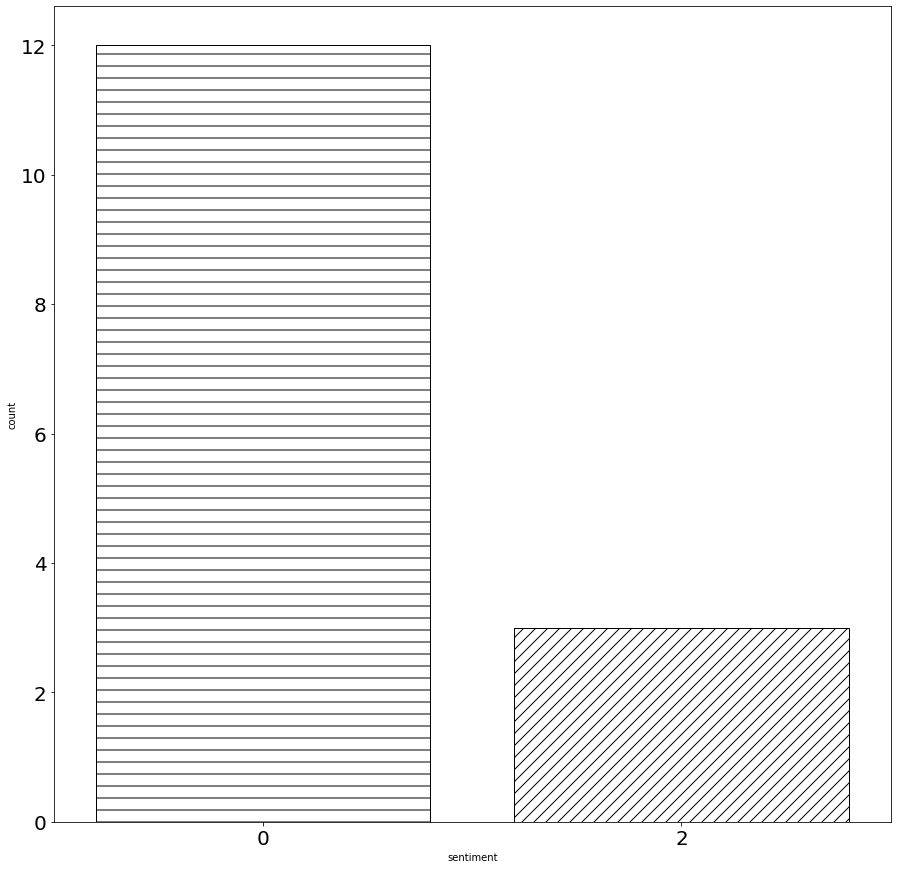

In [84]:
# vizualising the preds
plt.figure(figsize=(15,15))
ax = sns.countplot(predictions, color = 'white', edgecolor = 'black')
plt.xlabel('sentiment')
# ax.set_xticklabels(class_names);
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 20)

num_locations = len(predictions)
hatches = itertools.cycle(['-', '//', '+'])
for i, bar in enumerate(ax.patches):
    hatch = next(hatches)
    bar.set_hatch(hatch)
# plt.savefig(filename + ' cleaning_Balanced_Presentation.jpg')
#plt.savefig(filename + ' state.jpg')
#plt.savefig(filename + ' unbalanced.jpg')

3.3.1


In [136]:
# !pip install pyLDAvis==3.3.1
# print(pyLDAvis.__version__ )

In [132]:
## pyLDAVis
import pyLDAvis.gensim_models
from IPython.core.display import display,HTML
pyLDAvis.enable_notebook()

In [142]:
vis = pyLDAvis.gensim_models.prepare(lda_train4, train_corpus4_redt, dictionary= train_id2word_redt, mds = 'pcoa', sort_topics=True)
# pyLDAvis.display(vis)


/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/vickyyounang/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/vickyy

In [143]:
#vis = pyLDAvis.gensim_models.prepare(lda_topic_model, corpus, dictionary=lda_topic_model.id2word) 

pyLDAvis.save_html(vis, 'gensim_lda_result.html')

# then display the HTML output using IPython.core.display:

display(HTML('gensim_lda_result.html'))

In [137]:
# topics modeling

'''

num_topics=35

# Print the 8 most important words for each topic
print("Topics for reddit")
components_red,feat_names_red,lda_matrix_red = lda_pipeline_(df_sec_redt,num_topics)
# we will print only the 10 first
print_top_words_for_topic(components_red[:10], feat_names_red , 10)

num_topics=20

# Print the 8 most important words for each topic
print("\nTopics for twitter")
components_twi,feat_names_twi,lda_matrix_twi = lda_pipeline_(df_sec_twit,num_topics)
print_top_words_for_topic(components_twi[:10], feat_names_twi, 10)

'''

'\n\nnum_topics=35\n\n# Print the 8 most important words for each topic\nprint("Topics for reddit")\ncomponents_red,feat_names_red,lda_matrix_red = lda_pipeline_(df_sec_redt,num_topics)\n# we will print only the 10 first\nprint_top_words_for_topic(components_red[:10], feat_names_red , 10)\n\nnum_topics=20\n\n# Print the 8 most important words for each topic\nprint("\nTopics for twitter")\ncomponents_twi,feat_names_twi,lda_matrix_twi = lda_pipeline_(df_sec_twit,num_topics)\nprint_top_words_for_topic(components_twi[:10], feat_names_twi, 10)\n\n'

In [ ]:
sources:
    https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28
        https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24#:~:text=Topic%20modeling%20is%20a%20type,document%20to%20a%20particular%20topic.